# Imports

In [1]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 50.8 MB 15.6 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.3.1-py3-none-any.whl size=50916640 sha256=ffbc443e0751632a8a4e1bb94280661fb8cec2aa9a9a8e1ee9250823357c5189
  Stored in directory: /tmp/pip-ephem-wheel-cache-udde21yx/wheels/43/1d/c1/a0af68d0648debf57f875e9dda56bbac35cfc27bfa187ffc46
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [2]:
import spacy
from tqdm.notebook import tqdm
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from matplotlib import style
from scipy.sparse import hstack
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import en_core_web_md
from sklearn.feature_extraction.text import TfidfVectorizer
import gc
style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('/kaggle/input/200000-jeopardy-questions/JEOPARDY_CSV.csv', parse_dates=[' Air Date'], low_memory=False)
df.columns = ['Show_Number', 'Air_Date','Round','Category','Value','Question','Answer']
df.head()

,Show_Number,Air_Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


# Data Cleaning

## 1. Value
The value column contains string values in the format: $###. Lets convert it to integers.

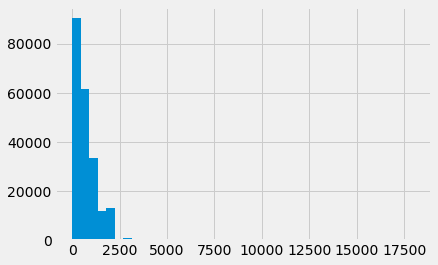

In [4]:
def fix_value_column(x):
    if x == 'None': return None
    x = x[1:] 
    x = x.replace(',', '')
    return x.strip()

df.Value = df.Value.map(fix_value_column).fillna(np.nan).astype('float')
df.Value.hist(bins=40)
plt.show()

According to the data description, The value of Final Jeopardy and Tie breaker Questions are None. So lets remove them.

In [5]:
print("Rounds where value is not None: ",df[~df['Value'].isna()].Round.unique())
print("Rounds where value is None: ",df[df['Value'].isna()].Round.unique())

Rounds where value is not None:  ['Jeopardy!' 'Double Jeopardy!']
Rounds where value is None:  ['Final Jeopardy!' 'Tiebreaker']


We can drop the columns with Value nan

In [6]:
df[df['Value'].isna()].isna().sum()

Show_Number       0
Air_Date          0
Round             0
Category          0
Value          3634
Question          0
Answer            0
dtype: int64

In [7]:
df_clean = df[df['Round'].isin(['Jeopardy!','Double Jeopardy!'])].reset_index(drop=True)

In [8]:
df_clean.isna().sum()

Show_Number    0
Air_Date       0
Round          0
Category       0
Value          0
Question       0
Answer         2
dtype: int64

There are two Answer's that are na. Let's check what the rows are!

In [9]:
df_clean[df_clean['Answer'].isna()]

,Show_Number,Air_Date,Round,Category,Value,Question,Answer
93230,4346,2003-06-23,Jeopardy!,"GOING ""N""SANE",200.0,"It often precedes ""and void""",NaN
140899,6177,2011-06-21,Double Jeopardy!,NOTHING,400.0,"This word for ""nothing"" precedes ""and void"" to...",NaN


The Question here looks like the text value for answer was `null` as the answer's seems to be null as in 'null and void'. Lets correct that.

In [10]:
df_clean['Answer']=df_clean['Answer'].fillna('Null')
df['Answer']=df['Answer'].fillna('Null')

A quick search on wikipedia and I found this:

>The 1984 series' first-round originally ranged from `$100` to `$500` (doubled again from the second pilot), and was doubled to `$200`–`$1,000` on November 26, 2001

Lets verify this

# Creating bins for Value

In [11]:
def create_bins(x):
    binning_fact = np.where(x>2000, 1000, 100)
    x = np.round(x/binning_fact) * binning_fact
    return x

In [12]:
df_clean['Value_bins'] = df_clean['Value'].apply(create_bins)
df_clean['Value_bins'] = df_clean['Value_bins'].clip(upper=10000)

In [13]:
before_26_Nov_2001 = df_clean[df_clean['Air_Date']<pd.to_datetime('26 Nov 2001')]
after_26_Nov_2001 = df_clean[df_clean['Air_Date']>=pd.to_datetime('26 Nov 2001')]

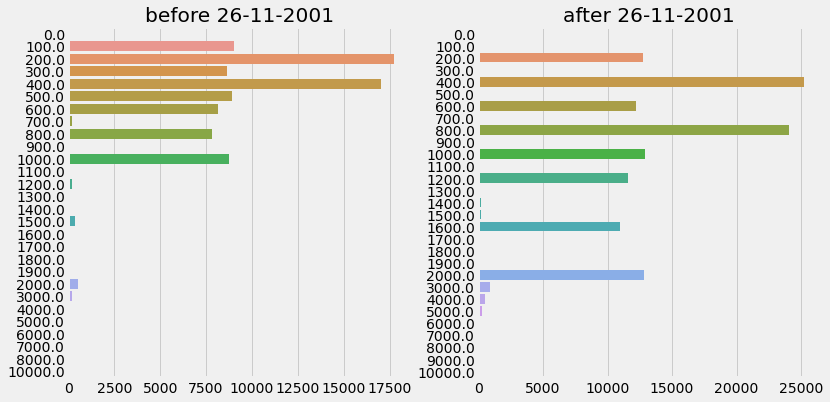

In [14]:
fig,axes = plt.subplots(1,2, figsize=(12,6))
bins_before = before_26_Nov_2001['Value_bins'].value_counts()
sns.barplot(x=bins_before.values, y=bins_before.index, orient='h',ax=axes[0])
bins_after = after_26_Nov_2001['Value_bins'].value_counts()
sns.barplot(x=bins_after.values, y=bins_after.index, orient='h',ax=axes[1])
axes[0].set_title('before 26-11-2001')
axes[1].set_title('after 26-11-2001')
plt.show()

We can clearly see that the values bins have been doubled after as stated in wikipedia

So what we can do is divide the Values after 26th November 2001 by 2 and use that to train the model. This will make it easier for the model to learn the relationships

In [15]:
df_clean.loc[after_26_Nov_2001.index,'Value'] = df_clean.loc[after_26_Nov_2001.index,'Value'].map(lambda x: x/2)

In [16]:
df_clean['Value_bins']=pd.cut(df_clean['Value'],[0,150,250,350,450,550,650,850,1500,2500,15000]).cat.codes

In [17]:
before_26_Nov_2001 = df_clean[df_clean['Air_Date']<pd.to_datetime('26 Nov 2001')]
after_26_Nov_2001 = df_clean[df_clean['Air_Date']>=pd.to_datetime('26 Nov 2001')]

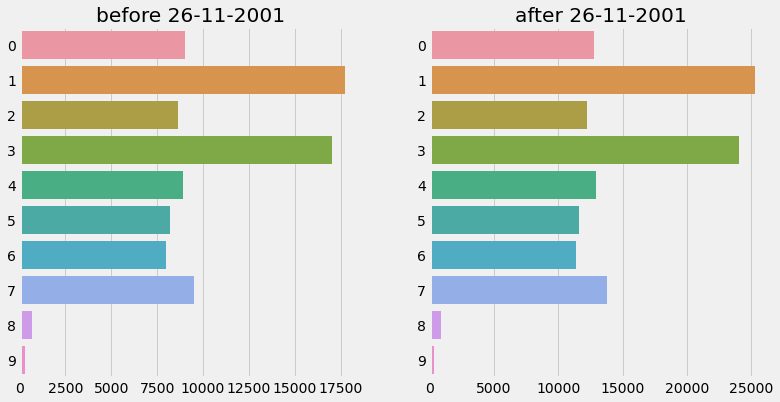

In [18]:
fig,axes = plt.subplots(1,2, figsize=(12,6))
bins_before = before_26_Nov_2001['Value_bins'].value_counts()
sns.barplot(x=bins_before.values, y=bins_before.index, orient='h',ax=axes[0])
bins_after = after_26_Nov_2001['Value_bins'].value_counts()
sns.barplot(x=bins_after.values, y=bins_after.index, orient='h',ax=axes[1])
axes[0].set_title('before 26-11-2001')
axes[1].set_title('after 26-11-2001')
plt.show()

We can see that the distribution now looks much better

# Feature Engineering

## 1. Processing Question

In [19]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

df_clean['Question'] = df_clean['Question'].apply(cleanhtml)

In [20]:
nlp = spacy.blank('en')
corpus = [];

for document in tqdm(df_clean['Question'].values):
    article = []
    doc = nlp(document)
    for token in doc:
        if not token.is_stop and not token.is_punct:
            article.append(token.lemma_.lower())
    corpus.append(article)

  0%|          | 0/213296 [00:00<?, ?it/s]

## 2.Answers

When using medium or large models in spacy, we can extract the embedding vectors from the models for the words. I will be using these embedding vectors for the answers. In case of multiple word answers, I will just take the mean of the word vectors.

In [21]:
nlp = en_core_web_md.load()
def vectorize(text):
    article = []
    doc = nlp(text)
    for token in doc:
        if not token.is_stop and not token.is_punct:
            article.append(token.vector)
            
    return np.vstack(article).mean(axis=0) if article else np.zeros((300,))
answers = np.array([vectorize(answer) for answer in tqdm(df_clean['Answer'].values)])
categories = np.array([vectorize(category) for category in tqdm(df_clean['Category'].values)])

  0%|          | 0/213296 [00:00<?, ?it/s]

  0%|          | 0/213296 [00:00<?, ?it/s]

## TFIDF Features

In [22]:
corpus_str = np.array([' '.join(doc) for doc in corpus])

tfidf_vec = TfidfVectorizer(max_features=3000)
tfidf_vec = tfidf_vec.fit(corpus_str)
tfidf_features = tfidf_vec.transform(corpus_str)

## One hot encoding Round

In [23]:
round_ohe = pd.get_dummies(df_clean[['Round']], columns=['Round'])

## Splitting the Data

In [24]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
splits = {}
for i, (trn_idx,val_idx) in enumerate(cv.split(df_clean, df_clean['Value_bins'])):
    splits[i] = {'train': trn_idx, 'valid': val_idx}

In [25]:
def get_data_for_split(idxs, answers=None, round_ohe=None, tfidf_features=None, categories=None):
    split_answers = answers[idxs] if answers is not None else None
    split_ohe = round_ohe.iloc[idxs] if round_ohe is not None else None
    split_tfidf = tfidf_features[idxs] if tfidf_features is not None else None
    split_categories = categories[idxs] if categories is not None else None
    features = []
    for feature in [split_answers, split_ohe, split_tfidf, split_categories]:
        if feature is None:
            continue
        features.append(feature)
    return hstack(features)

In [26]:
def get_labels(idxs):
    return df_clean.iloc[idxs]['Value_bins']

# Modelling with Logistic Regression

In [27]:
def get_oof_predictions(**features):
    models = {}
    oof = np.zeros(len(df_clean))
    for fold in tqdm(splits.keys()):
        train_idx, valid_idx = splits[fold]['train'],splits[fold]['valid']
        train_features = get_data_for_split(train_idx, **features)
        valid_features = get_data_for_split(valid_idx, **features)
        train_labels = get_labels(train_idx)
        valid_labels = get_labels(valid_idx)
        lr = LogisticRegression(max_iter=100, n_jobs=-1, verbose=0)
        lr.fit(train_features, train_labels)
        y_preds = lr.predict(valid_features)
        oof[valid_idx] = y_preds
        models[fold] = lr
    return oof, models

In [28]:
oof_tfidf, models_tfidf = get_oof_predictions(tfidf_features=tfidf_features)

  0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
print("###############\tOut Of Fold Metrics For TFIDF Features\t###############")
print(classification_report(df_clean['Value_bins'],oof_tfidf))
print('#'*56)

###############	Out Of Fold Metrics For TFIDF Features	###############


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.15      0.04      0.06     21784
           1       0.21      0.50      0.30     43030
           2       0.11      0.02      0.03     20872
           3       0.19      0.37      0.25     41115
           4       0.12      0.02      0.04     21840
           5       0.11      0.01      0.02     19797
           6       0.12      0.02      0.03     19371
           7       0.18      0.11      0.14     23309
           8       0.00      0.00      0.00      1562
           9       0.00      0.00      0.00       616

    accuracy                           0.20    213296
   macro avg       0.12      0.11      0.09    213296
weighted avg       0.16      0.20      0.14    213296

########################################################


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
oof_qa, models_qa = get_oof_predictions(tfidf_features=tfidf_features,answers=answers)

  0%|          | 0/5 [00:00<?, ?it/s]

In [31]:
print("###############\tOut Of Fold Metrics For Question and Answers\t###############")
print(classification_report(df_clean['Value_bins'],oof_qa))
print('#'*56)

###############	Out Of Fold Metrics For Question and Answers	###############


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.17      0.03      0.05     21784
           1       0.22      0.55      0.32     43030
           2       0.12      0.00      0.01     20872
           3       0.20      0.37      0.26     41115
           4       0.13      0.01      0.02     21840
           5       0.10      0.01      0.01     19797
           6       0.12      0.01      0.02     19371
           7       0.20      0.17      0.19     23309
           8       0.00      0.00      0.00      1562
           9       0.00      0.00      0.00       616

    accuracy                           0.21    213296
   macro avg       0.13      0.12      0.09    213296
weighted avg       0.17      0.21      0.15    213296

########################################################


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
oof_qar, models_qar = get_oof_predictions(tfidf_features=tfidf_features,answers=answers,round_ohe=round_ohe)

  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
print("###############\tOut Of Fold Metrics For Question, Answers, Rounds\t###############")
print(classification_report(df_clean['Value_bins'],oof_qar))
print('#'*56)

###############	Out Of Fold Metrics For Question, Answers, Rounds	###############
              precision    recall  f1-score   support

           0       0.25      0.36      0.30     21784
           1       0.24      0.31      0.27     43030
           2       0.20      0.13      0.16     20872
           3       0.20      0.14      0.17     41115
           4       0.26      0.33      0.29     21840
           5       0.19      0.09      0.13     19797
           6       0.19      0.09      0.12     19371
           7       0.27      0.41      0.32     23309
           8       0.00      0.00      0.00      1562
           9       0.00      0.00      0.00       616

    accuracy                           0.24    213296
   macro avg       0.18      0.19      0.18    213296
weighted avg       0.22      0.24      0.22    213296

########################################################


In [34]:
oof_qarc, models_qarc = get_oof_predictions(tfidf_features=tfidf_features,answers=answers,round_ohe=round_ohe,categories=categories)

  0%|          | 0/5 [00:00<?, ?it/s]

In [35]:
print("###############\tOut Of Fold Metrics For Question, Answers, Rounds, Categories\t###############")
print(classification_report(df_clean['Value_bins'],oof_qar))
print('#'*56)

###############	Out Of Fold Metrics For Question, Answers, Rounds, Categories	###############
              precision    recall  f1-score   support

           0       0.25      0.36      0.30     21784
           1       0.24      0.31      0.27     43030
           2       0.20      0.13      0.16     20872
           3       0.20      0.14      0.17     41115
           4       0.26      0.33      0.29     21840
           5       0.19      0.09      0.13     19797
           6       0.19      0.09      0.12     19371
           7       0.27      0.41      0.32     23309
           8       0.00      0.00      0.00      1562
           9       0.00      0.00      0.00       616

    accuracy                           0.24    213296
   macro avg       0.18      0.19      0.18    213296
weighted avg       0.22      0.24      0.22    213296

########################################################
